# Think Green Investing 

## Data Preparation

In [1]:
# Initial imports
import os
import requests
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
from datetime import datetime

%matplotlib inline

In [2]:
#intializing alpaca trade api
load_dotenv()
alpaca_api_key=os.getenv('ALPACA_API_KEY')
alpaca_secret_key=os.getenv('ALPACA_SECRET_KEY')
alpaca=tradeapi.REST(alpaca_api_key,alpaca_secret_key, api_version='v2')

In [3]:
#function that pulls tickers daily closing prices in the given time period using alpaca trade api, 
#intialization of the api is required before using.
#It returns a dataframe with the tickers, and closing prices as two level column structured datafram with index defined as date  

def get_tickers_data(tickers, start_date, end_date, timeframe):
    start_date = pd.Timestamp(start_date, tz = "America/New_York").isoformat()
    end_date = pd.Timestamp(end_date, tz = "America/New_York").isoformat()
    tickers_data_df = alpaca.get_bars(tickers, timeframe,start_date , end_date, adjustment = 'raw').df
    tickers_data_df.index = tickers_data_df.index.date
    tickers_data_df = tickers_data_df[['symbol', 'close']]
    tickers_data_list=[]
    for ticker in tickers:
        tickers_data_list.append(tickers_data_df[tickers_data_df['symbol']==ticker].drop('symbol', axis=1))
        
    clean_tickers_data = pd.concat(tickers_data_list,axis=1, keys=tickers)
    return clean_tickers_data

In [4]:
#defining the stocks in the solar energy portfolio form top performers in 2021 using mootley fool and investopedia. The companies are:
#1.First Solar (FSLR)
#2.Solar Edge Technologies (SEDG)
#3.Daqo New Energy Corp. (DQ)
#4.Canadian Solar INC (CSIQ)

tickers = ['SPY', 'NDAQ', 'FSLR' , 'SEDG', 'DQ','CSIQ']
timeframe='1Day'

start_date = '2018-01-01'
end_date = '2022-04-11'


tickers_data_five_years = get_tickers_data(tickers, start_date, end_date, timeframe) 

### Five Year Period Jan 2018 to April 2022

In [5]:
tickers_data_five_years.head()

,SPY,NDAQ,FSLR,SEDG,DQ,CSIQ
,close,close,close,close,close,close
2018-01-02,268.77,76.74,70.43,38.05,62.57,17.14
2018-01-03,270.47,77.66,69.80,39.05,63.14,17.07
2018-01-04,271.61,78.69,69.14,37.35,62.50,17.06
2018-01-05,273.42,79.21,69.17,37.90,64.78,17.01
2018-01-08,273.92,79.96,69.62,38.35,55.85,17.10


In [6]:
#Obtain daily returns 
daily_returns_five_years = tickers_data_five_years.pct_change()
daily_returns_five_years.head()

,SPY,NDAQ,FSLR,SEDG,DQ,CSIQ
,close,close,close,close,close,close
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.006325,0.011989,-0.008945,0.026281,0.009110,-0.004084
2018-01-04,0.004215,0.013263,-0.009456,-0.043534,-0.010136,-0.000586
2018-01-05,0.006664,0.006608,0.000434,0.014726,0.036480,-0.002931
2018-01-08,0.001829,0.009469,0.006506,0.011873,-0.137851,0.005291


<AxesSubplot:>

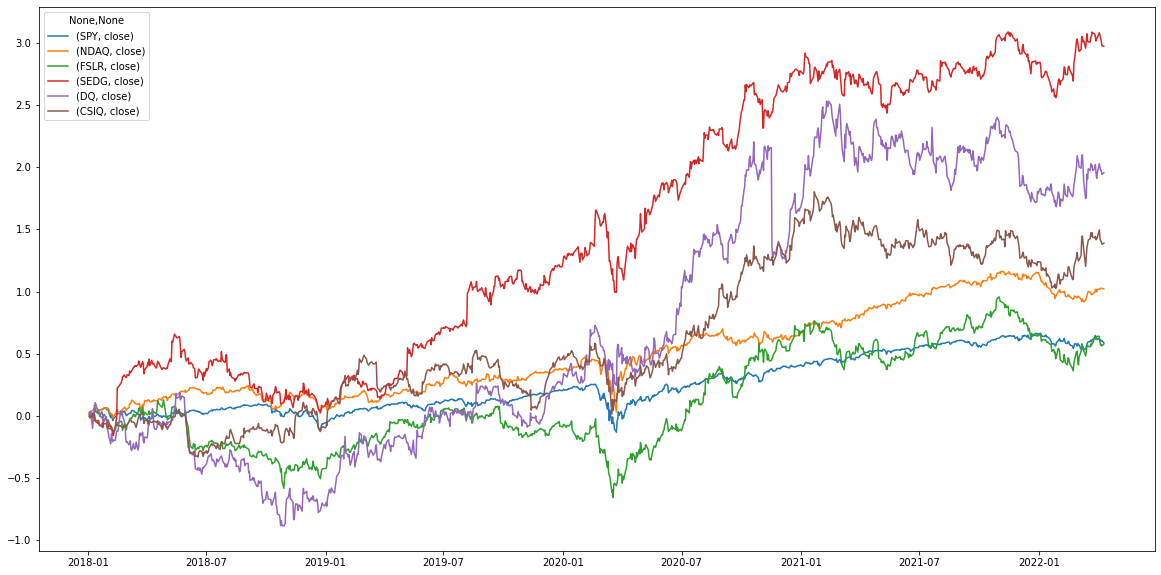

In [7]:
#Calculate cummulative returns 
cumulative_sum_five_years = daily_returns_five_years.cumsum()
#Plot cummulative returns for the last 5 years
cumulative_sum_five_years.plot(figsize=(20,10))

In [8]:
# Drop SPY to calculate mean of daily returns 
daily_returns_five_years2 = daily_returns_five_years.drop(columns=['SPY', 'NDAQ'])

In [9]:
# Calculate mean of daily returns of the portfolio
daily_returns_five_years2['solar_portfolio']=daily_returns_five_years2.mean(axis=1)
daily_returns_five_years2.head()

,FSLR,SEDG,DQ,CSIQ,solar_portfolio
,close,close,close,close,
2018-01-02,NaN,NaN,NaN,NaN,NaN
2018-01-03,-0.008945,0.026281,0.009110,-0.004084,0.005590
2018-01-04,-0.009456,-0.043534,-0.010136,-0.000586,-0.015928
2018-01-05,0.000434,0.014726,0.036480,-0.002931,0.012177
2018-01-08,0.006506,0.011873,-0.137851,0.005291,-0.028545


In [10]:
#Add SPY to new dataframe with mean
daily_returns_five_years3 = pd.concat([daily_returns_five_years2, daily_returns_five_years['SPY'], daily_returns_five_years['NDAQ']], axis="columns", join="inner")
#Fix Headers
daily_returns_five_years3.columns=['FSLR','SEDG','DQ','CSIQ','solar_portfolio', 'SPY', 'NDAQ']
daily_returns_five_years3.head()

,FSLR,SEDG,DQ,CSIQ,solar_portfolio,SPY,NDAQ
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,-0.008945,0.026281,0.009110,-0.004084,0.005590,0.006325,0.011989
2018-01-04,-0.009456,-0.043534,-0.010136,-0.000586,-0.015928,0.004215,0.013263
2018-01-05,0.000434,0.014726,0.036480,-0.002931,0.012177,0.006664,0.006608
2018-01-08,0.006506,0.011873,-0.137851,0.005291,-0.028545,0.001829,0.009469


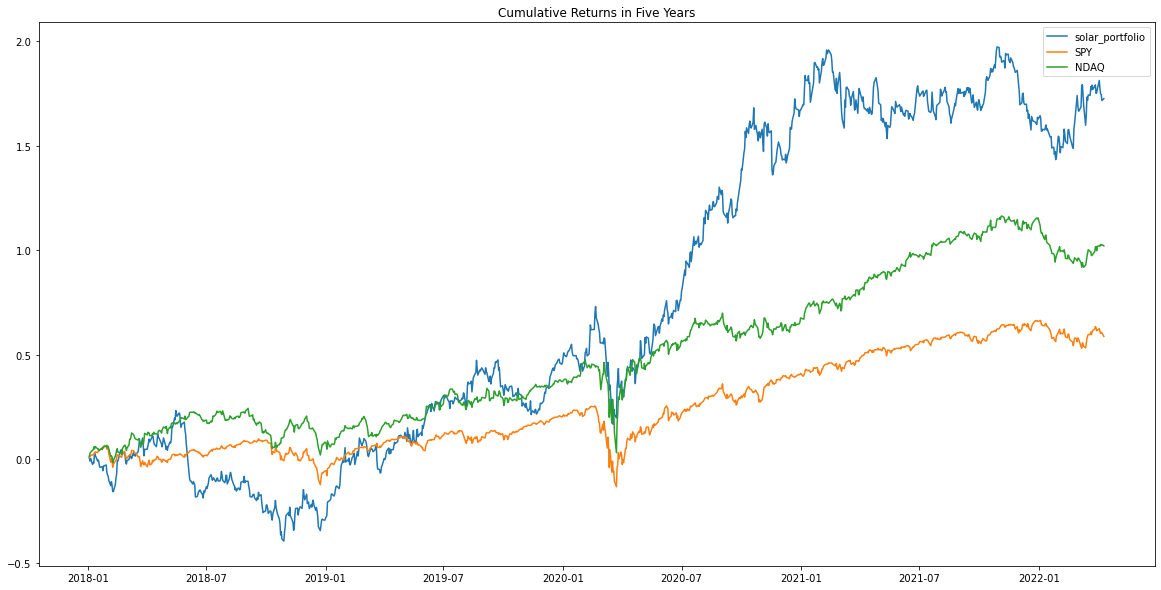

In [12]:
#Calculate cummulative Sum to plot mean vs SPY during war
cumulative_sum_five_years_2 = daily_returns_five_years3.cumsum()
#Compare average cummulative performance of portfolio vs SP500 during war
avg_performance_five_years = cumulative_sum_five_years_2[['solar_portfolio', 'SPY', 'NDAQ']].plot(figsize=(20,10), title="Cumulative Returns in Five Years")

<AxesSubplot:title={'center':'Stock Risk Analysis'}>

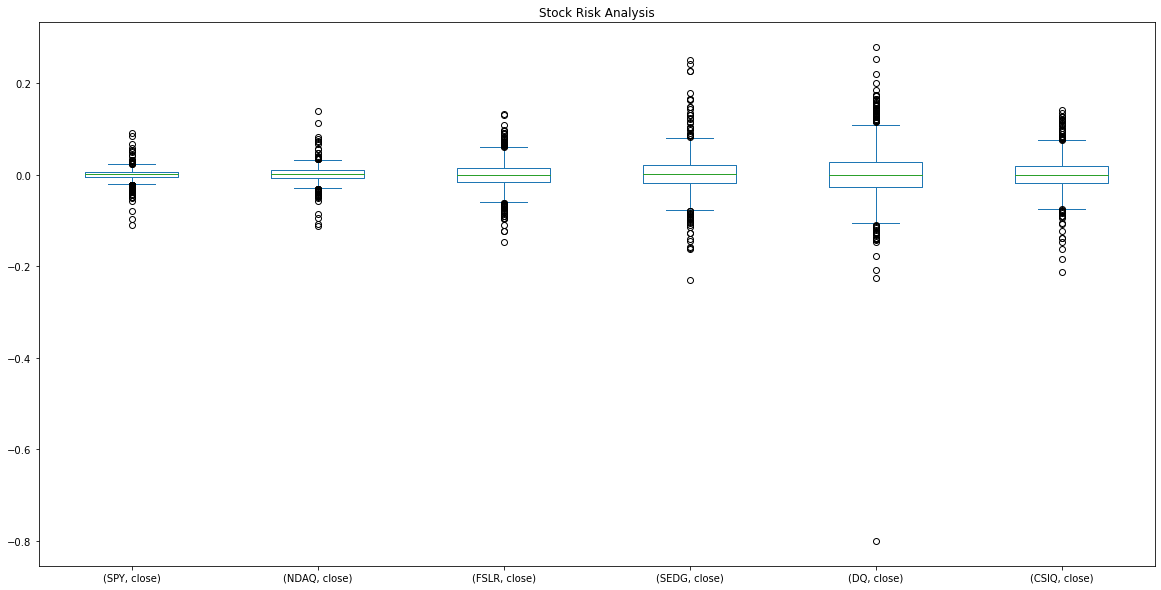

In [13]:
# Box plot to visually show risk
daily_returns_five_years.plot.box(figsize=(20, 10), title="Stock Risk Analysis")

In [17]:
# Calculate Standard Deviations
daily_returns_std_five_years = daily_returns_five_years.std()
daily_returns_std_five_years

SPY   close    0.013165
NDAQ  close    0.016967
FSLR  close    0.029358
SEDG  close    0.041394
DQ    close    0.058893
CSIQ  close    0.036097
dtype: float64

In [19]:
import matplotlib.pyplot as plt
from scipy.stats import norm

In [20]:
#plotly/hvplot to plot the standard deviation 

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

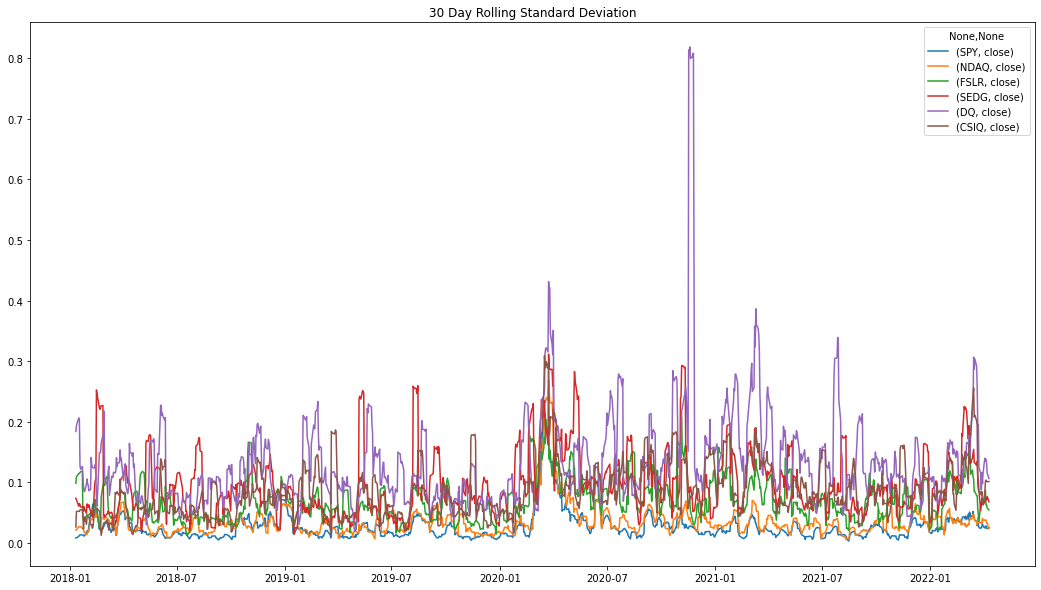

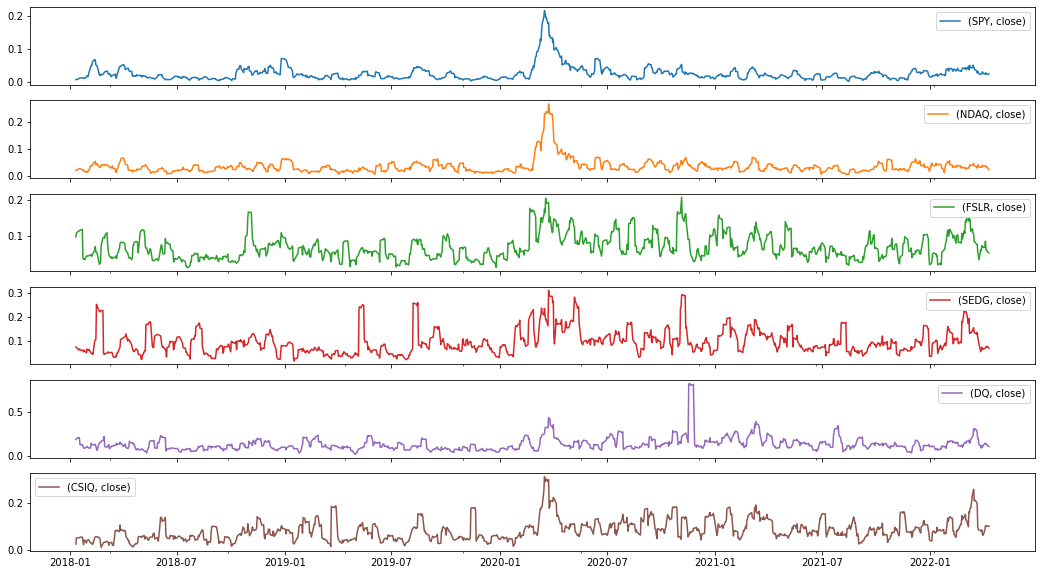

In [21]:
#Moving average for each time period of 30 days for the last five years using rolling standard deviation 
returns_five_years_std = daily_returns_five_years.rolling(7).std()*np.sqrt(7)
returns_five_years_std.plot(figsize = (18, 10), title="30 Day Rolling Standard Deviation")
returns_five_years_std.plot(figsize = (18, 10), subplots=True)

### Wartime Feb 2022 to April 2022

In [23]:
start_date_war = '2022-02-20'
end_date_war = '2022-04-11'

tickers_data_wartime = get_tickers_data(tickers, start_date_war, end_date_war, timeframe) 

tickers_data_wartime.head()

,SPY,NDAQ,FSLR,SEDG,DQ,CSIQ
,close,close,close,close,close,close
2022-02-22,429.57,168.97,65.85,246.07,38.03,26.52
2022-02-23,422.07,168.19,64.90,236.11,39.09,26.63
2022-02-24,428.30,170.19,69.04,271.19,41.68,29.10
2022-02-25,437.75,172.72,70.68,277.93,42.92,29.84
2022-02-28,436.63,171.15,75.29,319.42,47.96,31.66


In [24]:
# obtain daily returns Wartime
daily_returns_war = tickers_data_wartime.pct_change()
daily_returns_war.head()

,SPY,NDAQ,FSLR,SEDG,DQ,CSIQ
,close,close,close,close,close,close
2022-02-22,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-23,-0.017459,-0.004616,-0.014427,-0.040476,0.027873,0.004148
2022-02-24,0.014761,0.011891,0.063790,0.148575,0.066257,0.092753
2022-02-25,0.022064,0.014866,0.023754,0.024853,0.029750,0.025430
2022-02-28,-0.002559,-0.009090,0.065224,0.149282,0.117428,0.060992


<AxesSubplot:>

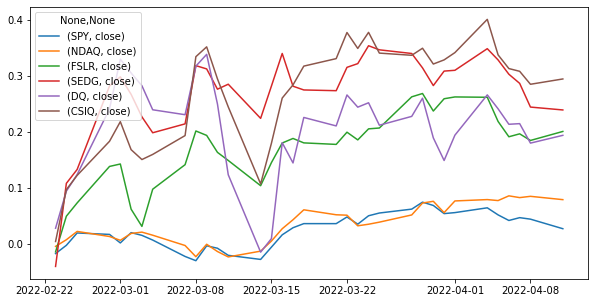

In [25]:
#Calculate cummulative returns Wartime
cumulative_sum_war = daily_returns_war.cumsum()
#Plot cummulative returns Wartime
cumulative_sum_war.plot(figsize=(10,5))

In [28]:
# Drop SPY to calculate mean of daily returns during war
daily_returns_war2 = daily_returns_war.drop(columns=['SPY', 'NDAQ'])
# Calculate mean of daily returns of the portfolio
daily_returns_war2['solar_portfolio']=daily_returns_war2.mean(axis=1)
daily_returns_war2.head()

,FSLR,SEDG,DQ,CSIQ,solar_portfolio
,close,close,close,close,
2022-02-22,NaN,NaN,NaN,NaN,NaN
2022-02-23,-0.014427,-0.040476,0.027873,0.004148,-0.005721
2022-02-24,0.063790,0.148575,0.066257,0.092753,0.092844
2022-02-25,0.023754,0.024853,0.029750,0.025430,0.025947
2022-02-28,0.065224,0.149282,0.117428,0.060992,0.098231


In [31]:
#Add SPY to new dataframe with mean
daily_returns_war_3 = pd.concat([daily_returns_war2, daily_returns_war['SPY'], daily_returns_war['NDAQ']], axis="columns", join="inner")
#Fix Headers
daily_returns_war_3.columns=['FSLR','SEDG','DQ','CSIQ','mean','SPY', 'NDAQ']
daily_returns_war_3.head()

,FSLR,SEDG,DQ,CSIQ,mean,SPY,NDAQ
2022-02-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-23,-0.014427,-0.040476,0.027873,0.004148,-0.005721,-0.017459,-0.004616
2022-02-24,0.063790,0.148575,0.066257,0.092753,0.092844,0.014761,0.011891
2022-02-25,0.023754,0.024853,0.029750,0.025430,0.025947,0.022064,0.014866
2022-02-28,0.065224,0.149282,0.117428,0.060992,0.098231,-0.002559,-0.009090


In [33]:
#Calculate cummulative Sum to plot mean vs SPY during war
cumulative_sum_war_2 = daily_returns_war_3.cumsum()

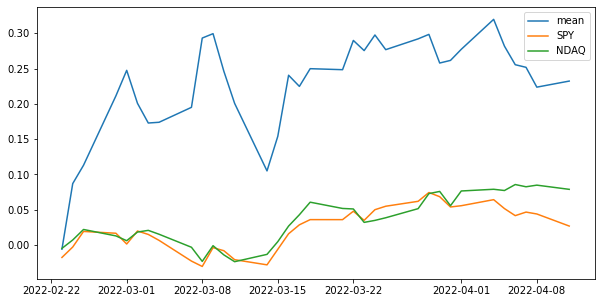

In [34]:
#Compare average cummulative performance of portfolio vs SP500 during war
avg_performance_war=cumulative_sum_war_2[['mean', 'SPY', 'NDAQ']].plot(figsize=(10,5))

In [35]:
# Calculate Standard Deviations War
daily_returns_std_war= daily_returns_war.std()
daily_returns_std_war

SPY   close    0.013896
NDAQ  close    0.012991
FSLR  close    0.034988
SEDG  close    0.050738
DQ    close    0.065612
CSIQ  close    0.052099
dtype: float64

<AxesSubplot:>

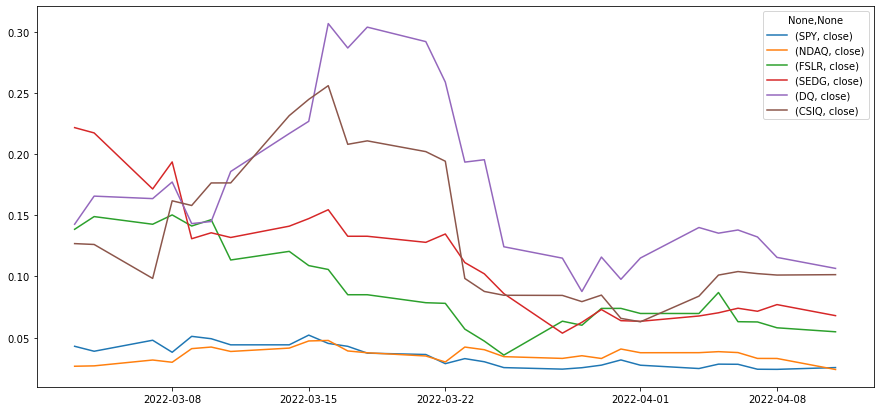

In [36]:
#Moving average for each time period of 7 days for the wartime period(shorter time frame)using rolling standard deviation 
returns_war_std = daily_returns_war.rolling(7).std()*np.sqrt(7)
returns_war_std.plot(figsize = (15, 7))

## Covid Time (Jan 2020 to Feb 2022)

In [37]:
# COVID time frame (~2 years)
start_date_covid = '2020-01-01'
end_date_covid = '2022-02-19'

tickers_data_covid = get_tickers_data(tickers, start_date_covid, end_date_covid, timeframe) 

In [38]:
#table= pd.pivot_table(yearly, values = 'close', index = [yearly.index], columns = ['symbol'])))
tickers_data_covid.head()

,SPY,NDAQ,FSLR,SEDG,DQ,CSIQ
,close,close,close,close,close,close
2020-01-02,324.87,107.82,57.24,101.81,54.98,22.520
2020-01-03,322.41,108.28,57.02,102.38,54.45,21.800
2020-01-06,323.64,108.21,55.83,99.63,53.85,22.320
2020-01-07,322.73,106.42,56.67,101.79,53.36,22.355
2020-01-08,324.45,105.83,56.70,104.16,54.38,22.570


In [39]:
#Calculate daily returns covid
daily_returns_covid = tickers_data_covid.pct_change()
daily_returns_covid

,SPY,NDAQ,FSLR,SEDG,DQ,CSIQ
,close,close,close,close,close,close
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,-0.007572,0.004266,-0.003843,0.005599,-0.009640,-0.031972
2020-01-06,0.003815,-0.000646,-0.020870,-0.026861,-0.011019,0.023853
2020-01-07,-0.002812,-0.016542,0.015046,0.021680,-0.009099,0.001568
2020-01-08,0.005330,-0.005544,0.000529,0.023283,0.019115,0.009618
...,...,...,...,...,...,...
2022-02-14,-0.003269,-0.002553,-0.015582,-0.003479,-0.015210,-0.008696
2022-02-15,0.016127,0.018089,0.056720,0.051922,0.082199,0.072003
2022-02-16,0.001121,-0.002171,-0.005964,0.017394,-0.012095,0.007501


In [40]:
#Calculate cummulative returns covid
cumulative_sum_covid = daily_returns_covid.cumsum()

<AxesSubplot:>

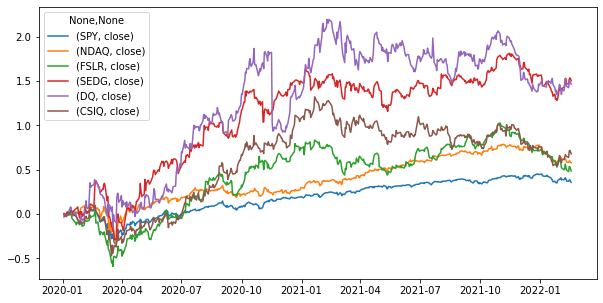

In [41]:
#Plot cummulative returns covid
cumulative_sum_covid.plot(figsize=(10,5))

In [42]:
# Drop SPY to calculate mean of daily returns
daily_returns_covid2 = daily_returns_covid.drop(columns=['SPY', 'NDAQ'])

In [43]:
# Calculate mean of daily returns of the portfolio
daily_returns_covid2['solar_portfolio'] = daily_returns_covid2.mean(axis=1)
daily_returns_covid2

,FSLR,SEDG,DQ,CSIQ,solar_portfolio
,close,close,close,close,
2020-01-02,NaN,NaN,NaN,NaN,NaN
2020-01-03,-0.003843,0.005599,-0.009640,-0.031972,-0.009964
2020-01-06,-0.020870,-0.026861,-0.011019,0.023853,-0.008724
2020-01-07,0.015046,0.021680,-0.009099,0.001568,0.007299
2020-01-08,0.000529,0.023283,0.019115,0.009618,0.013136
...,...,...,...,...,...
2022-02-14,-0.015582,-0.003479,-0.015210,-0.008696,-0.010742
2022-02-15,0.056720,0.051922,0.082199,0.072003,0.065711
2022-02-16,-0.005964,0.017394,-0.012095,0.007501,0.001709


In [45]:
#Add SPY to new dataframe with mean
daily_returns_covid_3 = pd.concat([daily_returns_covid2, daily_returns_covid['SPY'], daily_returns_covid['NDAQ']], axis="columns", join="inner")
#Fix Headers
daily_returns_covid_3.columns=['FSLR','SEDG','DQ','CSIQ','solar_portfolio','SPY', 'NDAQ']
daily_returns_covid_3

,FSLR,SEDG,DQ,CSIQ,solar_portfolio,SPY,NDAQ
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,-0.003843,0.005599,-0.009640,-0.031972,-0.009964,-0.007572,0.004266
2020-01-06,-0.020870,-0.026861,-0.011019,0.023853,-0.008724,0.003815,-0.000646
2020-01-07,0.015046,0.021680,-0.009099,0.001568,0.007299,-0.002812,-0.016542
2020-01-08,0.000529,0.023283,0.019115,0.009618,0.013136,0.005330,-0.005544
...,...,...,...,...,...,...,...
2022-02-14,-0.015582,-0.003479,-0.015210,-0.008696,-0.010742,-0.003269,-0.002553
2022-02-15,0.056720,0.051922,0.082199,0.072003,0.065711,0.016127,0.018089
2022-02-16,-0.005964,0.017394,-0.012095,0.007501,0.001709,0.001121,-0.002171
2022-02-17,-0.023999,-0.012972,-0.015671,-0.018613,-0.017814,-0.021317,-0.015917


In [47]:
#Calculate cummulative Sum to plot mean vs SPY during war
cumulative_sum_covid_3 = daily_returns_covid_3.cumsum()

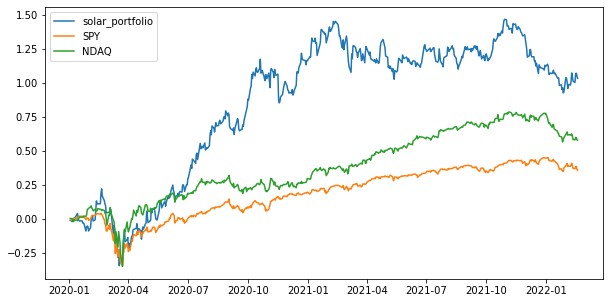

In [49]:
#Compare average cummulative performance of portfolio vs SP500
avg_performance_covid=cumulative_sum_covid_3[['solar_portfolio', 'SPY', 'NDAQ']].plot(figsize=(10,5))

In [50]:
# Calculate Standard Deviations covid
daily_returns_std_covid= daily_returns_covid.std()
daily_returns_std_covid

SPY   close    0.015841
NDAQ  close    0.020682
FSLR  close    0.033713
SEDG  close    0.046084
DQ    close    0.070248
CSIQ  close    0.040789
dtype: float64

<AxesSubplot:>

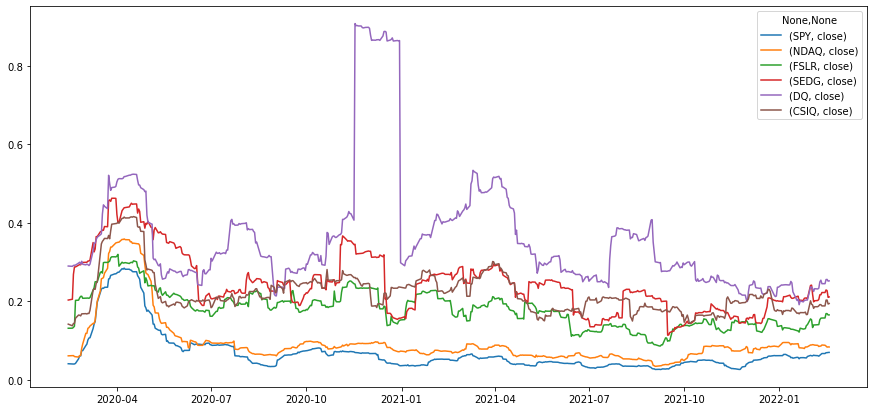

In [51]:
#Moving average for each time period of 30 days using rolling standard deviation 
returns_covid_std = daily_returns_covid.rolling(30).std()*np.sqrt(30)
returns_covid_std.plot(figsize = (15, 7))

## Pre Covid time (Jan 2018 to Dec 2019)

In [53]:
#Pre-Covid time frame (2 years)
start_date_pre_covid = '2018-01-01'
end_date_pre_covid = '2019-12-31'

tickers_data_pre_covid = get_tickers_data(tickers, start_date_pre_covid, end_date_pre_covid, timeframe) 
tickers_data_pre_covid

,SPY,NDAQ,FSLR,SEDG,DQ,CSIQ
,close,close,close,close,close,close
2018-01-02,268.77,76.74,70.43,38.05,62.57,17.14
2018-01-03,270.47,77.66,69.80,39.05,63.14,17.07
2018-01-04,271.61,78.69,69.14,37.35,62.50,17.06
2018-01-05,273.42,79.21,69.17,37.90,64.78,17.01
2018-01-08,273.92,79.96,69.62,38.35,55.85,17.10
...,...,...,...,...,...,...
2019-12-24,321.23,106.69,57.98,95.20,51.64,22.15
2019-12-26,322.94,107.79,58.66,95.56,51.51,22.32
2019-12-27,322.86,107.99,56.41,94.26,51.64,21.79


In [54]:
#Calculate daily returns pre covid
daily_returns_pre_covid = tickers_data_pre_covid.pct_change()
daily_returns_pre_covid

,SPY,NDAQ,FSLR,SEDG,DQ,CSIQ
,close,close,close,close,close,close
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.006325,0.011989,-0.008945,0.026281,0.009110,-0.004084
2018-01-04,0.004215,0.013263,-0.009456,-0.043534,-0.010136,-0.000586
2018-01-05,0.006664,0.006608,0.000434,0.014726,0.036480,-0.002931
2018-01-08,0.001829,0.009469,0.006506,0.011873,-0.137851,0.005291
...,...,...,...,...,...,...
2019-12-24,0.000031,-0.004479,0.002074,0.010830,0.011954,0.015589
2019-12-26,0.005323,0.010310,0.011728,0.003782,-0.002517,0.007675
2019-12-27,-0.000248,0.001855,-0.038357,-0.013604,0.002524,-0.023746


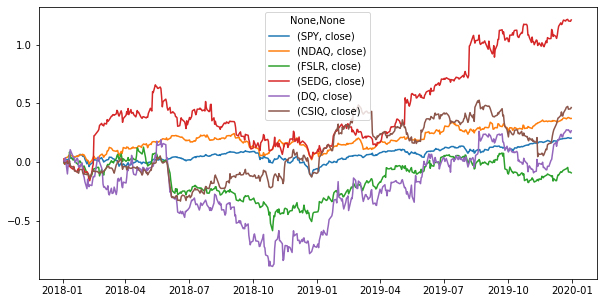

In [55]:
#Calculate cummulative returns Pre-Covid
Cumulative_Sum3 = daily_returns_pre_covid.cumsum()
#Plot Cummulative Returns Pre-Covid
cumulative_returns_pre_covid=Cumulative_Sum3.plot(figsize=(10,5))

In [59]:
# Calculate Standard Deviations War
returns_std_war= daily_returns_pre_covid.std()
returns_std_war

SPY   close    0.009473
NDAQ  close    0.012138
FSLR  close    0.023316
SEDG  close    0.034862
DQ    close    0.043036
CSIQ  close    0.028642
dtype: float64

## Pre Covid time (Jan 2018 to Dec 2019)

In [61]:
# pre-Covid time frame (2 years)
start_date_pre_covid = '2018-01-01'
end_date_pre_covid = '2019-12-31'

tickers_data_pre_covid = get_tickers_data(tickers, start_date_pre_covid, end_date_pre_covid, timeframe) 
tickers_data_pre_covid

,SPY,NDAQ,FSLR,SEDG,DQ,CSIQ
,close,close,close,close,close,close
2018-01-02,268.77,76.74,70.43,38.05,62.57,17.14
2018-01-03,270.47,77.66,69.80,39.05,63.14,17.07
2018-01-04,271.61,78.69,69.14,37.35,62.50,17.06
2018-01-05,273.42,79.21,69.17,37.90,64.78,17.01
2018-01-08,273.92,79.96,69.62,38.35,55.85,17.10
...,...,...,...,...,...,...
2019-12-24,321.23,106.69,57.98,95.20,51.64,22.15
2019-12-26,322.94,107.79,58.66,95.56,51.51,22.32
2019-12-27,322.86,107.99,56.41,94.26,51.64,21.79


In [62]:
#Calculate daily returns pre covid
daily_returns_pre_covid = tickers_data_pre_covid.pct_change()
daily_returns_pre_covid

,SPY,NDAQ,FSLR,SEDG,DQ,CSIQ
,close,close,close,close,close,close
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.006325,0.011989,-0.008945,0.026281,0.009110,-0.004084
2018-01-04,0.004215,0.013263,-0.009456,-0.043534,-0.010136,-0.000586
2018-01-05,0.006664,0.006608,0.000434,0.014726,0.036480,-0.002931
2018-01-08,0.001829,0.009469,0.006506,0.011873,-0.137851,0.005291
...,...,...,...,...,...,...
2019-12-24,0.000031,-0.004479,0.002074,0.010830,0.011954,0.015589
2019-12-26,0.005323,0.010310,0.011728,0.003782,-0.002517,0.007675
2019-12-27,-0.000248,0.001855,-0.038357,-0.013604,0.002524,-0.023746


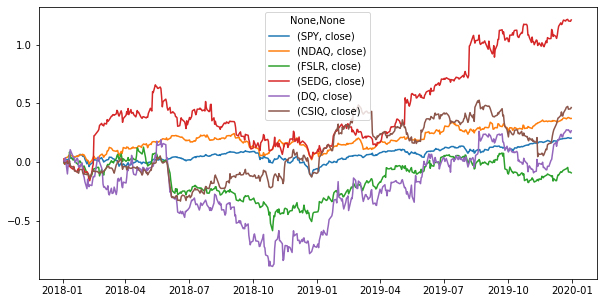

In [63]:
#Calculate cummulative returns Pre-Covid
Cumulative_Sum3 = daily_returns_pre_covid.cumsum()
#Plot Cummulative Returns Pre-Covid
cumulative_returns_pre_covid=Cumulative_Sum3.plot(figsize=(10,5))

In [64]:
# Drop SPY and NDAQ to calculate mean of daily returns pre-covid
daily_returns_pre_covid2 = daily_returns_pre_covid.drop(columns=['SPY', 'NDAQ'])
# Calculate mean of daily returns of the portfolio
daily_returns_pre_covid2['solar_portfolio'] = daily_returns_pre_covid2.mean(axis=1)
daily_returns_pre_covid2

,FSLR,SEDG,DQ,CSIQ,solar_portfolio
,close,close,close,close,
2018-01-02,NaN,NaN,NaN,NaN,NaN
2018-01-03,-0.008945,0.026281,0.009110,-0.004084,0.005590
2018-01-04,-0.009456,-0.043534,-0.010136,-0.000586,-0.015928
2018-01-05,0.000434,0.014726,0.036480,-0.002931,0.012177
2018-01-08,0.006506,0.011873,-0.137851,0.005291,-0.028545
...,...,...,...,...,...
2019-12-24,0.002074,0.010830,0.011954,0.015589,0.010112
2019-12-26,0.011728,0.003782,-0.002517,0.007675,0.005167
2019-12-27,-0.038357,-0.013604,0.002524,-0.023746,-0.018296


In [67]:
#Add SPY and NDAQ to new dataframe with mean
daily_returns_pre_covid_3 = pd.concat([daily_returns_pre_covid2, daily_returns_pre_covid['SPY'], daily_returns_pre_covid['NDAQ']], axis="columns", join="inner")
#Fix Headers
daily_returns_pre_covid_3.columns=['FSLR', 'SEDG', 'DQ', 'CSIQ', 'solar_portfolio', 'SPY', 'NDAQ']
daily_returns_pre_covid_3

,FSLR,SEDG,DQ,CSIQ,solar_portfolio,SPY,NDAQ
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,-0.008945,0.026281,0.009110,-0.004084,0.005590,0.006325,0.011989
2018-01-04,-0.009456,-0.043534,-0.010136,-0.000586,-0.015928,0.004215,0.013263
2018-01-05,0.000434,0.014726,0.036480,-0.002931,0.012177,0.006664,0.006608
2018-01-08,0.006506,0.011873,-0.137851,0.005291,-0.028545,0.001829,0.009469
...,...,...,...,...,...,...,...
2019-12-24,0.002074,0.010830,0.011954,0.015589,0.010112,0.000031,-0.004479
2019-12-26,0.011728,0.003782,-0.002517,0.007675,0.005167,0.005323,0.010310
2019-12-27,-0.038357,-0.013604,0.002524,-0.023746,-0.018296,-0.000248,0.001855
2019-12-30,-0.002659,-0.002758,-0.024787,0.003212,-0.006748,-0.005513,-0.008982


In [68]:
#Calculate cummulative Sum to plot mean vs SPY during war
cumulative_sum_pre_covid_3 = daily_returns_pre_covid_3.cumsum()

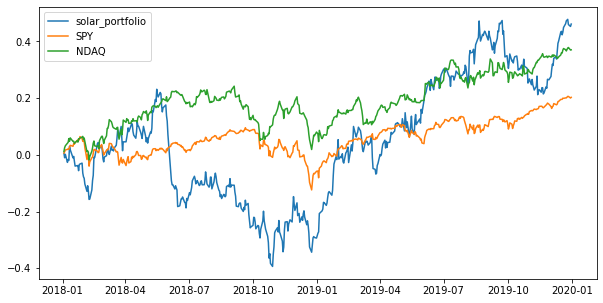

In [69]:
#Compare average cummulative performance of portfolio vs SP500
avg_performance_covid = cumulative_sum_pre_covid_3[['solar_portfolio', 'SPY', 'NDAQ']].plot(figsize=(10,5))

In [70]:
# Calculate Standard Deviations covid
daily_returns_std_pre_covid = daily_returns_pre_covid.std()
daily_returns_std_pre_covid

SPY   close    0.009473
NDAQ  close    0.012138
FSLR  close    0.023316
SEDG  close    0.034862
DQ    close    0.043036
CSIQ  close    0.028642
dtype: float64

<AxesSubplot:>

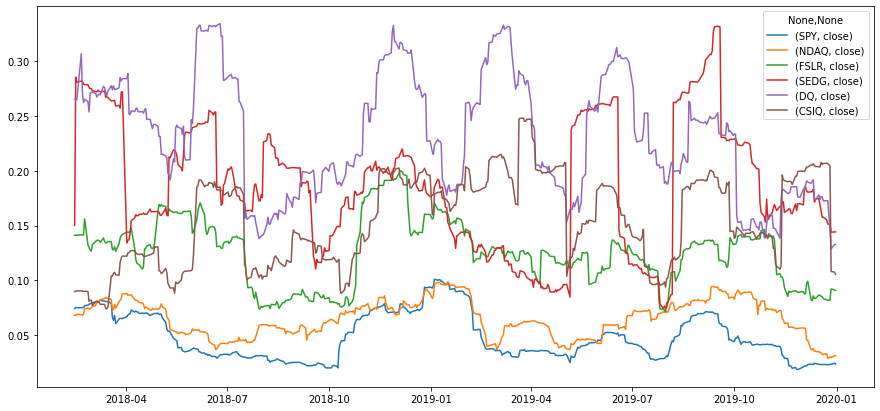

In [73]:
returns_pre_covid_std = daily_returns_pre_covid.rolling(30).std()*np.sqrt(30)
returns_pre_covid_std.plot(figsize = (15, 7))